### Identify Research Payment V.S. General Payment based on Medical Transaction features
The purpose of this analysis is to build a model to identify medical payment types <br>
This tesk is an aggregated workflow to build a ml process, more like in real cases <br>

The analysis including 3 parts <br>
#### 1. Understand features and select/create features
- drop features with too many missing value, taken into consideration as missing are not correlated to the final result
- winsorize / normalize variables, to avoid 
  - 1. curse of dimension when transforming categorical variable to lables 
  - 2. impact of outlier to the model, by transform the variable into normal distribution
- check data leakage, some of the feature have totally different value for Research payment v.s. General Payment. Understand how those 2 share similar features is critical to avoid data leakage

#### 2. Building model and train/select
- baseline model as tree and logistic regression to understand how features contribute to the result by looking at baseline model coefficients
- refine model by 
  - 1. grouping descriptions with regular expression to reduce dimension
  - 2. spliting some field that could be the combination of multiple dimensions
  - 3. try to find patterns in street/zip <br>
<b> select the model by <br>
  - 4. hyper parameter tuning with cross validation and random search
  - 5. ensemble (RF, Voting, XGBoosting)
    
#### 3. Findings
- amount of payment and location are the most important feature, especially if it is of higher amount and if in U.S. the probability for research funding is high
- also whether the payment is covered by insurance (covered by insurance indicate it is a general payment)
- what is payment method (cash indicate it is a general payment)
- what is the area of treatment, as the research fund is not similarly distributed as the general medical spend - for Oncology the payment is more likely to be research
- other reasons including devices, and code number for cases

#### 4. Result
- the predicted result 95% accuracy for testing set with runed tree, and 98 with XGB model

### Part 0. Sub Sampling the base
* imbalanced sample
* subsample method

In [176]:

## data processing
import pandas as pd
import numpy as np
import csv
 
import random  
import os

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#model selection
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import graphviz

# model evaluation
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import r2_score
import datetime

In [4]:

total_gen_row=11239734#sum(1 for i in open('OP_DTL_GNRL_PGYR2017_P06282019.csv'))
total_res_row=653489#sum(1 for i in open('OP_DTL_RSRCH_PGYR2017_P06282019.csv'))

total_gen_row,total_res_row
#(11239734, 653489)

nsamples_res=200000

skiprows_gen = np.sort(np.random.choice(range(1, total_gen_row), replace = False, size = total_gen_row - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, total_res_row), replace = False, size = total_res_row - nsamples_res))


In [5]:

gen = pd.read_csv("OP_DTL_GNRL_PGYR2017_P06282019.csv", skiprows = skiprows_gen, parse_dates=['Date_of_Payment'])
res = pd.read_csv("OP_DTL_RSRCH_PGYR2017_P06282019.csv", skiprows = skiprows_res, parse_dates=['Date_of_Payment'])


C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (16,17,21,22,23,24,67,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,5,7,8,9,10,17,18,19,20,21,22,23,24,37,38,44,45,50,52,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,151,156,161,162,163) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
gen.to_csv('gen.csv')

In [9]:
res.to_csv('res.csv')

In [5]:
gen=pd.read_csv('gen.csv')
res=pd.read_csv('res.csv')

C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,18,22,23,24,25,68,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,6,8,9,10,11,18,19,20,21,22,23,24,25,38,39,45,46,51,53,63,68,69,70,71,72,73,74,75,76,77,80,81,82,88,89,90,91,92,93,94,95,96,97,100,101,102,108,109,110,111,112,113,114,115,116,117,120,121,122,152,157,162,163,164) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 warnings show mixed types of data in multiple columns, which is a sign to 
    1. check the null and missing value
    2. check whether some numerical value is converted into categorical or vice versa

### Part 1. Understand Features

In [13]:
gen.shape,res.shape

((199999, 75), (199999, 176))

Feature could be grouped by feature name at the first glance
1. check data type
2. check feature unique value
3. check feature null value
4. check data leakage

In [6]:
gen['Tag']=0
res['Tag']=1

In [7]:
#combine 2 sets of data with different result to 1, leaving columns that are in common in both sets
#the common features are 66
comb=pd.concat([gen,res],axis=0,verify_integrity=False,sort=True,join="inner")
comb.shape

In [8]:
comb.shape

(399998, 66)

Create a table showing each variable''s missing ratio and unique value

In [13]:
#unique check

unique=pd.DataFrame(comb.groupby('Tag').nunique())
unique_dfT=unique.T
unique_dfT['Overall_Unique']=comb.nunique()
unique_dfT.columns=['0_unique','1_unique','Overall_Unique']

#null check
def null_check(x):
    return sum(x.isnull())

nulldf=comb.groupby('Tag').agg(null_check) 
nulldfT=nulldf.T

nulldfT.rename(columns={0: "0_Null", 1: "1_Null"},inplace=True)
nulldfT['Overall_Null_Ratio']    =nulldfT.apply(lambda x:sum(x[:2]),axis=1)/400000
nulldfT['0_Null_Ratio']    =nulldfT['0_Null']/200000
nulldfT['1_Null_Ratio']    =nulldfT['1_Null']/200000 
dfinfo=pd.concat([nulldfT,unique_dfT],axis=1) 

dfinfo.shape

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
dfinfo

C:\Users\Yilun\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [23]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
dfinfo

,0_Null,1_Null,Overall_Null_Ratio,0_Null_Ratio,1_Null_Ratio,0_unique,1_unique,Overall_Unique
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,0.0,0.0,0.000000,0.000000,0.000000,20,18,24
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,0.0,0.0,0.000000,0.000000,0.000000,1009,562,1126
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,0.0,0.0,0.000000,0.000000,0.000000,1022,569,1155
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,1738.0,19704.0,0.053605,0.008690,0.098520,42,35,44
Associated_Drug_or_Biological_NDC_1,53897.0,102822.0,0.391798,0.269485,0.514110,925,658,1111
Associated_Drug_or_Biological_NDC_2,161457.0,196124.0,0.893953,0.807285,0.980620,400,35,415
Associated_Drug_or_Biological_NDC_3,186352.0,199578.0,0.964825,0.931760,0.997890,258,14,268
Associated_Drug_or_Biological_NDC_4,196669.0,199902.0,0.991428,0.983345,0.999510,132,6,136
Associated_Drug_or_Biological_NDC_5,199511.0,199949.0,0.998650,0.997555,0.999745,46,4,50
Change_Type,0.0,0.0,0.000000,0.000000,0.000000,4,4,4


Criteria to drop feature
1. too much missing
all Associated_Drug_or_Biological_NDC_2 - 5
2. no overlapping value for research or general

In [14]:
# quick func to check the top in categorical data
def top_cat(X):
    l1=comb[comb['Tag']==0][X].value_counts()[:10]
    l2=comb[comb['Tag']==1][X].value_counts()[:10]
    print('gen')
    print(l1)
    print('res')
    print(l2)
    print('In common')
    print(len(set(l1.index).intersection(set(l2.index))))

In [53]:
top_cat("Associated_Drug_or_Biological_NDC_1")

gen
50458-580-30    5106
0169-4060-90    4537
00031-062-10    3713
0078-0659-20    3097
55513-710-01    2712
50458-140-30    2655
0006-0277-82    2408
0002-1433-80    2205
00597-0152-0    2194
0074-4339-02    2173
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
res
0006-3029-01    9569
62856-529-60    8506
64406-006-02    3553
0597-0140-30    2828
0169-2660-15    2751
65757-300-01    2083
0597-0152-30    1914
0069-0187-21    1788
0024-5901-00    1718
62856-710-30    1570
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
In common
0


this shows this metric highly likely leaking information or providing really distinguishable value <br>
Considering there are overlap between the 2, we might want to add it back

In [54]:
top_cat("Covered_or_Noncovered_Indicator_1")

gen
Covered        185343
Non-Covered      5078
Name: Covered_or_Noncovered_Indicator_1, dtype: int64
res
Covered        125299
Non-Covered     48416
Name: Covered_or_Noncovered_Indicator_1, dtype: int64
In common
2


In [55]:
top_cat("Product_Category_or_Therapeutic_Area_1")

gen
Diabetes                         10129
RESPIRATORY                       9173
Cardiovascular & Metabolism       7845
Immunology                        6088
CARDIOVASCULAR                    5757
NEUROSCIENCE                      5246
Endocrinology                     5144
Cardiovascular and Metabolism     4788
GASTROENTEROLOGY                  4546
DIABETES                          4251
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
res
ONCOLOGY                        17976
Nutrition and Weight Loss        8506
Oncology                         7939
DIABETES                         7699
Diabetes                         6411
Cardiology/Vascular Diseases     5854
NEUROLOGY                        5851
CNS                              3767
Immunology                       3748
CARDIOVASCULAR                   3553
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
In common
4


The above 2 is normal, no need to drop

 build a filter of thefinal columns <br>
 rule on missing value 
1. overall missing >60%
2. research or general missing >80%


In [56]:
dfinfo.columns

Index(['0_Null', '1_Null', 'Overall_Null_Ratio', '0_Null_Ratio',
       '1_Null_Ratio', '0_unique', '1_unique', 'Overall_Unique'],
      dtype='object')

In [15]:
dfinfo_1=dfinfo[(dfinfo['0_Null_Ratio']<0.8)&(dfinfo['1_Null_Ratio']<0.8)&(dfinfo['Overall_Null_Ratio']<0.6)&(dfinfo['Overall_Unique']>1)&(dfinfo['Overall_Unique']<399997)]

In [16]:
var_set_1=dfinfo_1.index

In [17]:
comb.loc[:,var_set_1].dtypes

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country            object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID                  int64
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name               object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State              object
Associated_Drug_or_Biological_NDC_1                                         object
Change_Type                                                                 object
Covered_Recipient_Type                                                      object
Covered_or_Noncovered_Indicator_1                                           object
Date_of_Payment                                                     datetime64[ns]
Dispute_Status_for_Publication                                              object
Form_of_Payment_or_Transfer_of_Value                                        object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1                   object
Name

In [77]:
top_cat("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID")

gen
100000000286    10537
100000000278     8937
100000000232     8504
100000000146     7886
100000000144     7179
100000000053     6955
100000000203     6147
100000005449     5931
100000000228     5845
100000000234     5754
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64
res
100000000286    14400
100000000053    13319
100000000263    12007
100000000136    10836
100000000255     8724
100000000067     8723
100000000204     7754
100000000163     6681
100000000193     5899
100000010579     5474
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64
In common
2


In [78]:
top_cat("Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1")

gen
XARELTO      5112
Victoza      4537
FARXIGA      3713
ENTRESTO     3093
ELIQUIS      3024
JARDIANCE    2733
Prolia       2712
INVOKANA     2665
JANUVIA      2408
TRULICITY    2205
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
res
KEYTRUDA               9569
Belviq                 8506
TECFIDERA              3553
TRADJENTA              2828
Tresiba                2751
Non-Covered Product    2508
Sentus                 2216
Vivitrol 380mg         2083
SAR231893              1950
JARDIANCE              1851
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
In common
1


In [ ]:
# except for amount, drop those cat var who has more than 100 cont

In [18]:
var_set_2=dfinfo_1[(dfinfo_1['Overall_Unique']<100)].index

In [19]:
var_2=var_set_2.tolist()
var_2.append('Total_Amount_of_Payment_USDollars')

### Step 2. Bivariate analysis

(array([7.50000e+01, 1.64100e+03, 2.25130e+04, 1.65282e+05, 7.36010e+04,
        8.51800e+04, 4.22620e+04, 8.77900e+03, 6.31000e+02, 3.40000e+01]),
 array([-4.60517019, -2.48019474, -0.3552193 ,  1.76975614,  3.89473159,
         6.01970703,  8.14468247, 10.26965792, 12.39463336, 14.5196088 ,
        16.64458425]),
 <a list of 10 Patch objects>)

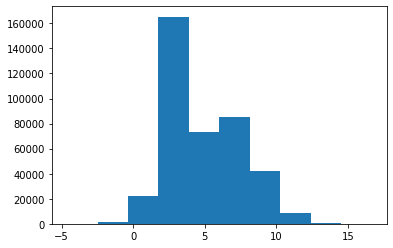

In [10]:
#first check the cont var : payment dollar
plt.hist(np.log(comb.Total_Amount_of_Payment_USDollars))

In [11]:
comb.groupby('Tag').mean()['Total_Amount_of_Payment_USDollars']

Tag
0     311.429872
1    7634.153894
Name: Total_Amount_of_Payment_USDollars, dtype: float64

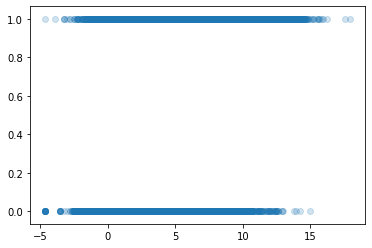

In [98]:
plt.scatter(np.log(comb.Total_Amount_of_Payment_USDollars),comb.Tag,alpha=0.2)

In [ ]:
# then check categorical variables

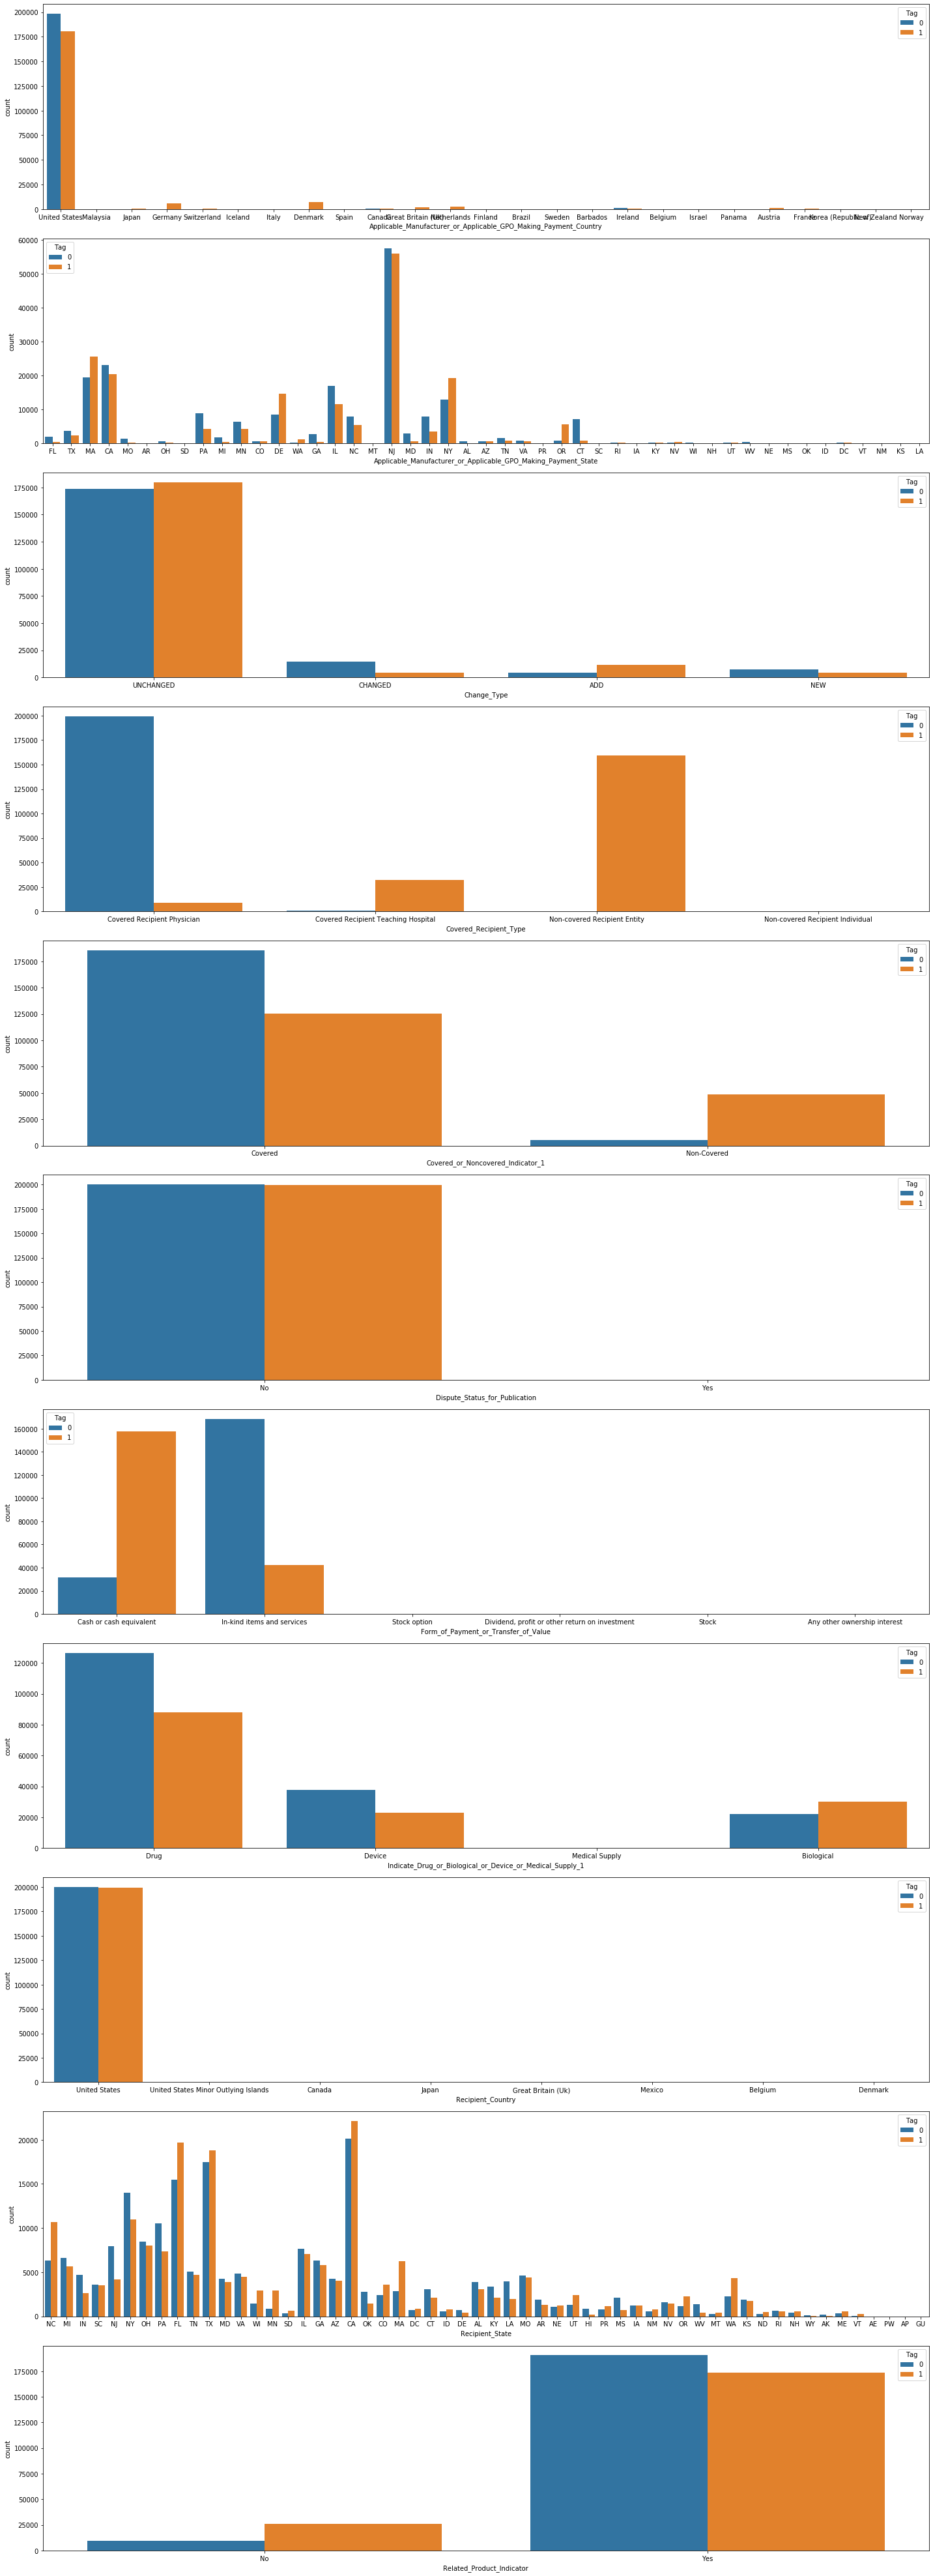

In [109]:
fig, ax = plt.subplots(  len(var_2[:-1]), figsize = (20, len(var_2[:-1])*5))
i=0
for v in var_2[:-1]:
    sns.countplot(v, hue='Tag', data = comb, ax = ax[i])
    i+=1

plt.tight_layout()

change type is a highly likely variable to be leaking result
need to be dropped

In [36]:
var_2

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Change_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Dispute_Status_for_Publication',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Recipient_Country',
 'Recipient_State',
 'Related_Product_Indicator',
 'Total_Amount_of_Payment_USDollars']

In [32]:
var_2.remove('Covered_Recipient_Type')


### Step 3. Modeling

1. fill missing as 'NA'

In [ ]:
comb_reg=comb.copy()[var_2]
comb_reg.fillna('NA',inplace=True)
X_trainval,X_test,y_trainval,y_test=train_test_split(comb_reg,comb['Tag'])
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval)

cat=comb_reg.dtypes=='object'
cont=comb_reg.dtypes!='object'

prep = ColumnTransformer([("OneHot", OneHotEncoder(handle_unknown='ignore'),cat), ('pt', 'passthrough',cont)])

log = Pipeline([('preprocessing', prep), ('LogReg',LogisticRegression())])

log.fit(X_train,y_train)

#LogReg seems to have a fair result. Check the actual parameter for the model -- which variable plays a more important role
 

log.score(X_train,y_train)

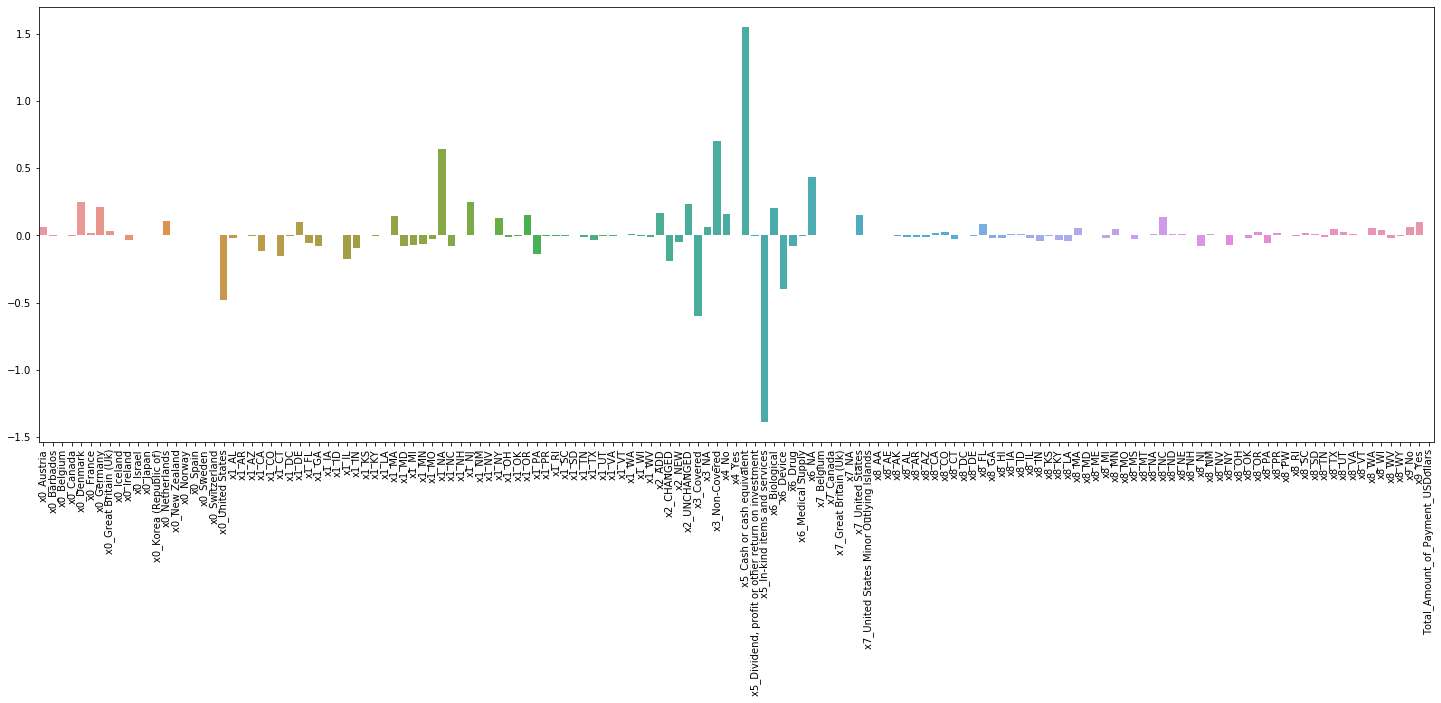

In [81]:
cols = log.named_steps['preprocessing'].named_transformers_['OneHot'].get_feature_names().tolist() \
+ ['Total_Amount_of_Payment_USDollars']
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=cols, y=log.named_steps['LogReg'].coef_[0])
plt.show()

In [ ]:
# second model is tree

In [82]:
tree = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.03,
                                     
                                        min_samples_leaf=400, min_samples_split=400,
                                        min_weight_fraction_leaf=0.01,))])

tree.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree.score(X_train,y_train),tree.score(X_test,y_test)))

tree_dot = export_graphviz(tree.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

tree training accuracy: 0.878 and test accuracy: 0.877


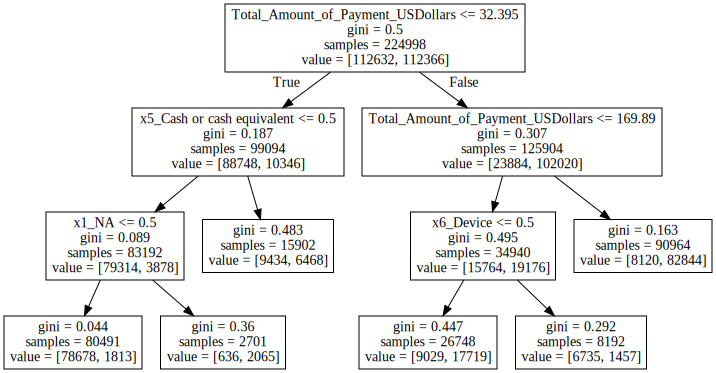

In [88]:
tree = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.01,
                                     
                                        min_samples_leaf=20, min_samples_split=40,
                                        min_weight_fraction_leaf=0.0001,))])

tree.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree.score(X_train,y_train),tree.score(X_test,y_test)))

tree_dot = export_graphviz(tree.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

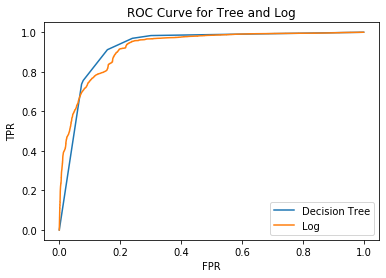

In [89]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, log.predict_proba(X_test)[:,1])
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.plot(fpr_tree, tpr_tree, label = 'Decision Tree')
plt.plot(fpr_log, tpr_log, label = 'Log')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Tree and Log")
plt.legend()
plt.show()

### Step 4 Refining the variables
1. those vars that dropped due to so many categories, check whether we can aggregate them
2. for string var, use NLP to check 

In [93]:
comb_reg.reset_index(inplace=True)
comb_reg.drop('index',axis=1,inplace=True)

ValueError: cannot insert level_0, already exists

In [95]:
comb_reg.columns

Index(['level_0', 'index',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Change_Type', 'Covered_or_Noncovered_Indicator_1',
       'Dispute_Status_for_Publication',
       'Form_of_Payment_or_Transfer_of_Value',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Recipient_Country', 'Recipient_State', 'Related_Product_Indicator',
       'Total_Amount_of_Payment_USDollars'],
      dtype='object')

In [27]:
top_cat("Associated_Drug_or_Biological_NDC_1")

gen
50458-580-30    4988
0169-4060-90    4756
00031-062-10    3789
0078-0659-20    3189
50458-140-30    2724
55513-710-01    2724
0002-1433-80    2294
0006-0277-82    2244
00597-0152-0    2229
0074-4339-02    2157
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
res
0006-3029-01    9568
62856-529-60    8493
64406-006-02    3538
0597-0140-30    2782
0169-2660-15    2732
65757-300-01    2109
0597-0152-30    1920
0069-0187-21    1788
0024-5901-00    1755
62856-710-30    1645
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
In common
0


In [17]:
#break them down and check the pattern
s=[]
for  i in comb[ "Associated_Drug_or_Biological_NDC_1"].fillna('0-0-0'): 
    s.append(i.split('-'))
NDC_1_DF=pd.DataFrame(s,columns=['dig1','dig2','dig3'])              

In [102]:
comb_modify=pd.concat([comb_reg,NDC_1_DF],axis=1)

In [18]:
for i in ['dig1','dig2','dig3']: 
    l=comb_modify[i].value_counts()[:10].index.tolist()
    comb_modify[i] = np.where([i in l for i in comb_modify[i]], comb_modify[i],'0')

for this variable, we want to break down into 3 digits and leave the top 10 unchanged for each one

check Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID  and leave top 10 category

In [103]:
l=comb.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID.value_counts()[:20]

l.index

[i in l.index for i in comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] ]

comb_modify['Applicable_Manufacturer_or_Applicable_GPO_M']=\
np.where([i in l.index for i in comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] ],\
         comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'],'000000000000')

CHECK DATE OF PAYMENT

In [104]:
comb_modify['Payment_Weekday']=\
pd.to_datetime(comb['Date_of_Payment']).apply(lambda x:str(x.weekday())).tolist()

In [105]:
comb_modify['Payment_Month']=\
pd.to_datetime(comb['Date_of_Payment']).apply(lambda x:str(x.month)).tolist()

Check name of drug

In [153]:
comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].value_counts()

KEYTRUDA                             9995
Belviq                               8641
Victoza                              5820
XARELTO                              5621
JARDIANCE                            4614
                                     ... 
Oryx and Lotus                          1
Provox Laryngectomy Pulmonary Kit       1
SELF-CATH                               1
SHIFT                                   1
RECOMBIVAX HIB                          1
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, Length: 5026, dtype: int64

In [154]:
top_cat('Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1')

gen
XARELTO      4998
Victoza      4756
FARXIGA      3789
ENTRESTO     3184
ELIQUIS      3047
JARDIANCE    2751
INVOKANA     2730
Prolia       2724
TRULICITY    2294
JANUVIA      2244
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
res
KEYTRUDA               9568
Belviq                 8493
TECFIDERA              3538
TRADJENTA              2782
Tresiba                2732
Non-Covered Product    2487
Sentus                 2232
Vivitrol 380mg         2109
SAR231893              1888
JARDIANCE              1863
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
In common
1


This the type of drug associated with the payment, <br>
Standardize the format and try to extract key element

In [106]:
conv=comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].apply(lambda x:str(x).lower())#.value_counts()

conv=comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].apply(lambda x:str(x).lower())
l=conv.value_counts()[:20]

comb_modify['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M']=\
np.where([i in l.index for i in conv],conv,'Other')

check 'Product_Category_or_Therapeutic_Area_1'

In [163]:
top_cat("Product_Category_or_Therapeutic_Area_1")

gen
Diabetes                         10319
RESPIRATORY                       9065
Cardiovascular & Metabolism       7788
Immunology                        6023
CARDIOVASCULAR                    5875
NEUROSCIENCE                      5375
Endocrinology                     5060
Cardiovascular and Metabolism     4865
GASTROENTEROLOGY                  4661
Oncology                          4316
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
res
ONCOLOGY                        18090
Nutrition and Weight Loss        8493
Oncology                         7688
DIABETES                         7604
Diabetes                         6485
Cardiology/Vascular Diseases     5975
NEUROLOGY                        5788
Immunology                       3878
CNS                              3803
CARDIOVASCULAR                   3596
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
In common
4


In [107]:
conv=comb['Product_Category_or_Therapeutic_Area_1'].apply(lambda x:str(x).lower())
l=conv.value_counts()[:20]

comb_modify['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M']=\
np.where([i in l.index for i in conv],conv,'Other')

check Therapeutic Area

In [109]:
comb_modify['Product_Category']=comb['Product_Category_or_Therapeutic_Area_1'].apply(lambda x:str(x).lower()).tolist()

In [110]:
comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('resp', regex=True), 'resp', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('diab', regex=True), 'diab', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('oncol', regex=True), 'oncol', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('cardio', regex=True), 'cardio', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('nero', regex=True), 'nero', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('immun', regex=True), 'immun', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('gastro', regex=True), 'gastro', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains\
                                           ('resp|diab|oncol|cardio|nero|immun|gastro', regex=True), comb_modify['Product_Category'], 'other')


In [111]:
comb_modify['Product_Category'].value_counts()

other     252194
cardio     40909
oncol      38574
diab       29288
resp       16542
immun      14425
gastro      8066
Name: Product_Category, dtype: int64

In [176]:
top_cat('Recipient_Primary_Business_Street_Address_Line1')

gen
9500 EUCLID AVE            226
11100 EUCLID AVE           175
2500 N STATE ST            161
200 1ST ST SW              139
5323 HARRY HINES BLVD      128
10666 N TORREY PINES RD    124
100 E LANCASTER AVE        122
3800 RESERVOIR RD NW       114
6550 FANNIN ST             103
3400 SPRUCE ST              95
Name: Recipient_Primary_Business_Street_Address_Line1, dtype: int64
res
1 Triangle Dr                1838
12221 MERIT DR STE 500        920
619 SOUTH 19TH STREET         808
1515 HOLCOMBE BLVD            738
2301 COMMONWEALTH BLVD        532
450 BROOKLINE AVE             505
175 CROSS KEYS ROAD           477
11818 WILSHIRE BLVD           461
1211 MEDICAL CENTER DRIVE     440
3730 S EASTERN AVE            429
Name: Recipient_Primary_Business_Street_Address_Line1, dtype: int64
In common
0


the address field is hard to extract any information

In [177]:
top_cat('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name')

gen
Janssen Pharmaceuticals, Inc                  11108
Pfizer Inc.                                   10609
Allergan Inc.                                  9052
AstraZeneca Pharmaceuticals LP                 8224
Novo Nordisk Inc                               7504
Merck Sharp & Dohme Corporation                6763
Amgen Inc.                                     6076
Novartis Pharmaceuticals Corporation           5970
GlaxoSmithKline, LLC.                          5838
Boehringer Ingelheim Pharmaceuticals, Inc.     5687
Name: Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name, dtype: int64
res
Pfizer Inc.                                   15205
Merck Sharp & Dohme Corporation               13370
Incyte Corporation                            12030
Eisai Inc.                                    10933
Sanofi and Genzyme US Companies               10713
Boehringer Ingelheim Corporate Center GmbH     9723
Alkermes, Inc.                                 8919
AbbVie, Inc.                  

In [112]:
GPO=comb['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'].fillna('NA').apply(lambda x: x.lower().split(' ')[0])

L=GPO.value_counts()[:10].index

comb_modify['GPO_M']=[i if i in L else 'other' for i in GPO ]

comb_modify['GPO_M'].value_counts()

other          241971
pfizer          25655
merck           20426
sanofi          16674
boehringer      16564
janssen         16563
novo            14274
abbvie,         13110
incyte          12231
astrazeneca     11420
eisai           11110
Name: GPO_M, dtype: int64

### Step 5. Refining Models

In [113]:
comb_modify.to_csv('comb_modify.csv')

In [4]:
comb_modify=pd.read_csv('comb_modify.csv')

In [12]:
comb_modify['Total_Amount_of_Payment_USDollars']=np.log(comb['Total_Amount_of_Payment_USDollars'].tolist())

In [34]:
comb_modify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399998 entries, 0 to 399997
Data columns (total 20 columns):
Unnamed: 0                                                          399998 non-null int64
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    399998 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      399998 non-null object
Covered_or_Noncovered_Indicator_1                                   399998 non-null object
Dispute_Status_for_Publication                                      399998 non-null object
Form_of_Payment_or_Transfer_of_Value                                399998 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           399998 non-null object
Recipient_Country                                                   399998 non-null object
Recipient_State                                                     399998 non-null object
Related_Product_Indicator                                           399

In [128]:
comb_modify.drop('Applicable_Manufacturer_or_Applicable_GPO_M',axis=1,inplace=True)

In [129]:
comb_modify.head()

,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Covered_or_Noncovered_Indicator_1,Dispute_Status_for_Publication,Form_of_Payment_or_Transfer_of_Value,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Recipient_Country,Recipient_State,Related_Product_Indicator,Total_Amount_of_Payment_USDollars,dig1,dig2,dig3,Payment_Weekday,Payment_Month,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M,Product_Category,GPO_M
0,United States,TX,Covered,No,In-kind items and services,Drug,United States,PA,Yes,2.438863,0,0,30,5,8,Other,other,other
1,United States,FL,NA,No,Cash or cash equivalent,NA,United States,OR,No,3.099642,0,0,0,6,4,NA,other,other
2,United States,FL,NA,No,Cash or cash equivalent,NA,United States,CA,No,4.759349,0,0,0,1,3,NA,other,other
3,United States,TX,Covered,No,In-kind items and services,Drug,United States,NY,Yes,2.573375,0,0,0,4,10,Other,other,other
4,United States,TX,Covered,No,In-kind items and services,Drug,United States,PA,Yes,2.778819,0,0,30,1,10,Other,other,other


In [36]:
comb_modify.drop('Unnamed: 0',axis=1,inplace=True )

In [ ]:
comb_modify['dig1']=comb_modify['dig1'].astype(str)   
comb_modify['dig2']=comb_modify['dig2'].astype(str)  
comb_modify['dig3']=comb_modify['dig3'].astype(str)  

In [59]:
comb_modify['Payment_Month']=comb_modify['Payment_Month'].astype(str)  
comb_modify['Payment_Weekday']=comb_modify['Payment_Weekday'].astype(str)  
comb_modify['Applicable_Manufacturer_or_Applicable_GPO_M']=comb_modify['Applicable_Manufacturer_or_Applicable_GPO_M'].astype(str)  

In [60]:
X_trainval,X_test,y_trainval,y_test=train_test_split(comb_modify,comb['Tag'])
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval)

In [61]:
comb_modify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399998 entries, 0 to 399997
Data columns (total 19 columns):
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    399998 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      399998 non-null object
Covered_or_Noncovered_Indicator_1                                   399998 non-null object
Dispute_Status_for_Publication                                      399998 non-null object
Form_of_Payment_or_Transfer_of_Value                                399998 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           399998 non-null object
Recipient_Country                                                   399998 non-null object
Recipient_State                                                     399998 non-null object
Related_Product_Indicator                                           399998 non-null object
Total_Amount_of_Payment_USDollars                                   39

In [15]:
comb_modify.fillna('NA',inplace=True)

In [53]:
comb_modify.nunique()

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country       23
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State         47
Covered_or_Noncovered_Indicator_1                                       3
Dispute_Status_for_Publication                                          2
Form_of_Payment_or_Transfer_of_Value                                    5
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1               5
Recipient_Country                                                      11
Recipient_State                                                        58
Related_Product_Indicator                                               2
Total_Amount_of_Payment_USDollars                                   75059
dig1                                                                   10
dig2                                                                   10
dig3                                                                   10
Applicable_Manufacturer_or_Applicable_

Rerun log reg

In [ ]:
X_trainval,X_test,y_trainval,y_test=train_test_split(comb_modify,comb['Tag'])
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval)

In [108]:
cat

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country     True
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State       True
Covered_or_Noncovered_Indicator_1                                    True
Dispute_Status_for_Publication                                       True
Form_of_Payment_or_Transfer_of_Value                                 True
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1            True
Recipient_Country                                                    True
Recipient_State                                                      True
Related_Product_Indicator                                            True
Total_Amount_of_Payment_USDollars                                   False
dig1                                                                 True
dig2                                                                 True
dig3                                                                 True
Applicable_Manufacturer_or_Applicable_

In [102]:
cat=comb_modify.dtypes=='object'
cont=comb_modify.dtypes!='object'

prep = ColumnTransformer([("OneHot", OneHotEncoder(handle_unknown='ignore'),cat), ('pt', 'passthrough',cont)])

In [109]:
log_pipe = Pipeline([('preprocessing', prep), ('LogReg',LogisticRegression(penalty='l1',solver='saga',C=1))])

log_pipe.fit(X_train,y_train)

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OneHot',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                n_values=None,
                                                                sparse=True),
                                                  Applicable_Manufacturer_or_Applicable_GPO_...
Name_of_Drug_or_

In [64]:
#LogReg seems to have a fair result. Check the actual parameter for the model -- which variable plays a more important role
log_pipe.score(X_train,y_train)

0.944359505417826

In [65]:
log_pipe.score(X_test,y_test)

0.94271

In [66]:
len(log_pipe.named_steps['LogReg'].coef_[0])

261

In [68]:
cols = log_pipe.named_steps['preprocessing'].named_transformers_['OneHot'].get_feature_names().tolist() \
+ ['Total_Amount_of_Payment_USDollars']

In [69]:
len(cols)

261

In [73]:
a={i:j for i,j in zip(cols,  log_pipe.named_steps['LogReg'].coef_[0])}

In [78]:
outcome=pd.Series(a)

In [88]:
for i ,j in enumerate(comb_modify.columns[cat]):
    print(i,j)

0 Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country
1 Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State
2 Covered_or_Noncovered_Indicator_1
3 Dispute_Status_for_Publication
4 Form_of_Payment_or_Transfer_of_Value
5 Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
6 Recipient_Country
7 Recipient_State
8 Related_Product_Indicator
9 dig1
10 dig2
11 dig3
12 Applicable_Manufacturer_or_Applicable_GPO_M
13 Payment_Weekday
14 Payment_Month
15 Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M
16 Product_Category
17 GPO_M


In [85]:
outcome.sort_values()[:4]

(Index(['x12_100000000232', 'x12_100000000234', 'x12_100000000144', 'x10_152'], dtype='object'),
 x12_100000000232   -8.269934
 x12_100000000234   -7.221079
 x12_100000000144   -6.589039
 x10_152            -3.001802
 dtype: float64)

In [89]:
outcome.sort_values()[-4:]

x12_100000010579    4.736432
x12_100000000163    5.310122
x12_100000000067    6.660959
x17_boehringer      7.259178
dtype: float64

variables with most important power are those fine tuned vars

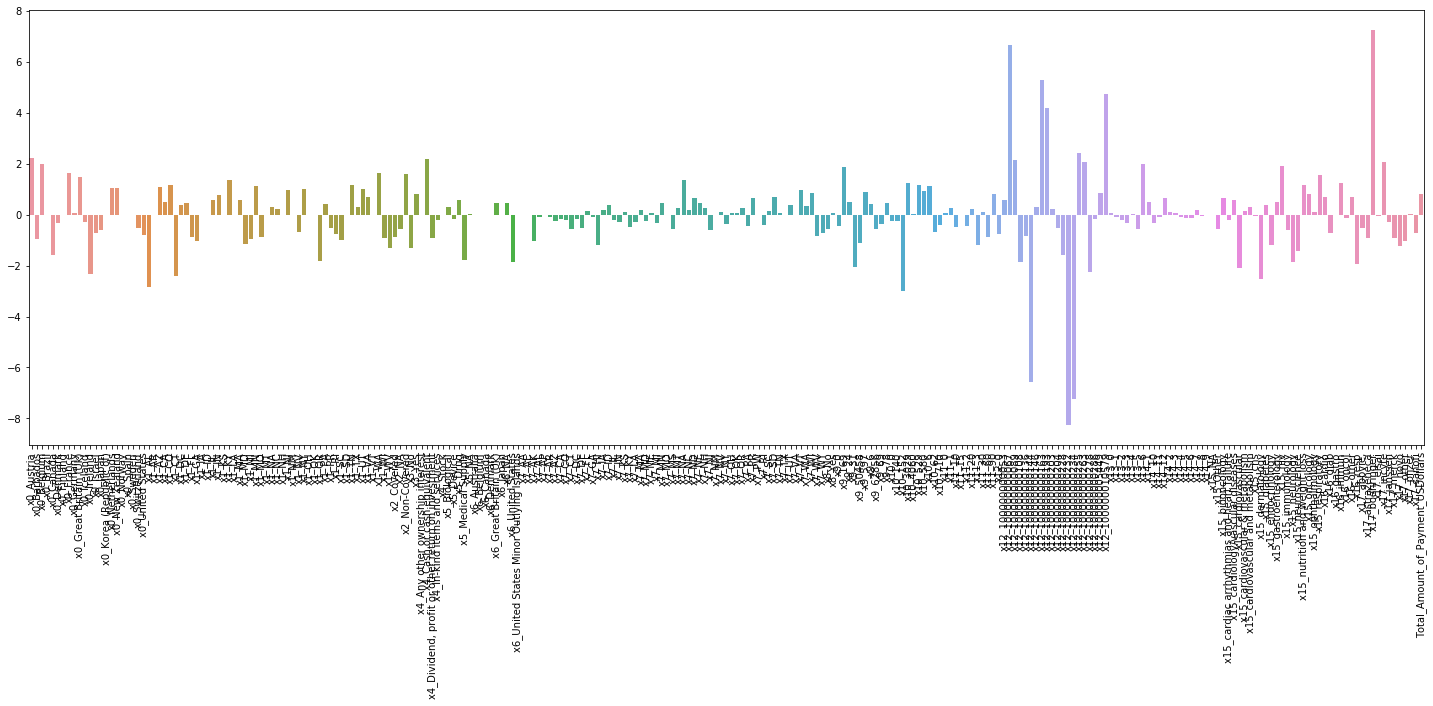

In [70]:

fig, ax = plt.subplots(1, 1, figsize=(25, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=cols, y=log_pipe.named_steps['LogReg'].coef_[0])
plt.show()

In [43]:
#cross validation
param_grid_logr = {'LogReg__C': np.logspace(-3, 2, 6)}

grid_logr = GridSearchCV(log_pipe, param_grid_logr, cv=3, n_jobs=-1).fit(X_train, y_train)

In [44]:
res = pd.DataFrame(grid_logr.cv_results_)

In [46]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LogReg__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.518065,1.096841,0.759453,0.140694,0.001,{'LogReg__C': 0.001},0.638533,0.639449,0.634755,0.637579,0.002031,6
1,10.574476,0.975294,0.802119,0.207989,0.01,{'LogReg__C': 0.01},0.645133,0.646649,0.642262,0.644681,0.001819,5
2,11.488757,1.226887,0.781254,0.098168,0.1,{'LogReg__C': 0.1},0.645480,0.647062,0.642329,0.644957,0.001967,4
3,13.069168,1.324641,0.790214,0.115983,1,{'LogReg__C': 1.0},0.646120,0.646982,0.641875,0.644992,0.002232,3
4,12.728244,0.888214,0.777529,0.025456,10,{'LogReg__C': 10.0},0.645800,0.646942,0.642595,0.645112,0.001840,1
5,9.895734,1.809515,0.485009,0.071907,100,{'LogReg__C': 100.0},0.645787,0.646915,0.642622,0.645108,0.001817,2


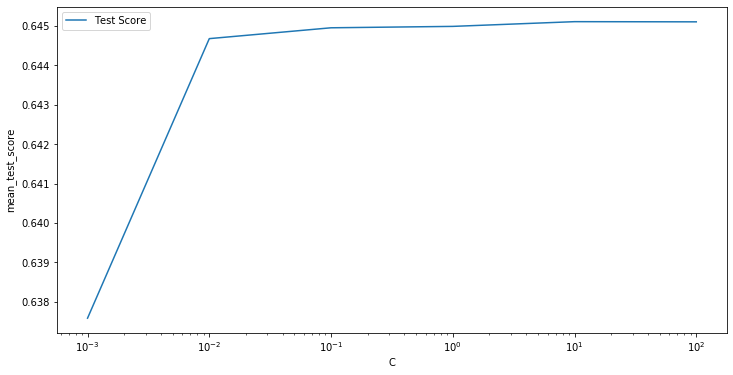

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

##sns.lineplot(x='param_LogReg__C', y='mean_train_score', data=res, label='Train Score')
sns.lineplot(x='param_LogReg__C', y='mean_test_score', data=res, label='Test Score')

ax.set_xlabel('C')
plt.xscale("log")
plt.legend()
plt.show()

In [90]:
tree_pipe = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.01,
                                     
                                        min_samples_leaf=20, min_samples_split=20,
                                        min_weight_fraction_leaf=0.001))])

In [91]:
tree_pipe.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree_pipe.score(X_train,y_train),tree_pipe.score(X_test,y_test)))

tree training accuracy: 0.848 and test accuracy: 0.847


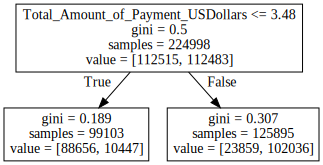

In [92]:
tree_dot = export_graphviz(tree_pipe.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

In [93]:
tree_pipe = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.01,
                                     
                                        min_samples_leaf=20, min_samples_split=20,
                                        min_weight_fraction_leaf=0.001))])

In [ ]:
tree_pipe.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree_pipe.score(X_train,y_train),tree_pipe.score(X_test,y_test)))

In [ ]:
tree_dot = export_graphviz(tree_pipe.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

In [97]:
for i,j in zip(cols,tree_pipe.named_steps['Tree'].feature_importances_):
    if j!=0:
        print(i,j)

x1_NA 0.04277439647415692
x12_100000000193 0.03719061339729068
x12_100000000263 0.05197537224759333
x15_Other 0.04580634261572859
Total_Amount_of_Payment_USDollars 0.8222532752652304


In [ ]:
# try RF and grid search for parameter tuning

In [104]:
voting = VotingClassifier(
    [('logreg', LogisticRegression(C=100)),
     ('tree', DecisionTreeClassifier(max_depth=3, random_state=0))],
    voting='soft')
voting_pipe = Pipeline([('preprocessing', prep), ('Volting',voting)])

In [101]:
X_train.shape

(224998, 19)

In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224998 entries, 75524 to 74228
Data columns (total 19 columns):
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    224998 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      224998 non-null object
Covered_or_Noncovered_Indicator_1                                   224998 non-null object
Dispute_Status_for_Publication                                      224998 non-null object
Form_of_Payment_or_Transfer_of_Value                                224998 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           224998 non-null object
Recipient_Country                                                   224998 non-null object
Recipient_State                                                     224998 non-null object
Related_Product_Indicator                                           224998 non-null object
Total_Amount_of_Payment_USDollars                                  

In [2]:
#voting.fit(X_train, y_train)
 
#voting.score(X_test, y_test) 

feature selection might be slow for current setting

In [ ]:
def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y, cv=5))
    scores = []
    for feature in range(X.shape[1]):
        mask = np.ones(X.shape[1], 'bool')
        mask[feature] = False
        X_new = X[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y, cv=5))
        scores.append(base_score - this_score)
    return np.array(scores)

In [ ]:
#try rf

In [ ]:
gbrt = GradientBoostingRegressor().fit(X_train, y_train)
fig, axs = plot_partial_dependence(
    gbrt, X_train, np.argsort(gbrt.feature_importances_)[-6:],
    feature_names=boston.feature_names, n_jobs=3,
    grid_resolution=50)

In [ ]:
# get rid of pipline and convert all predictor in advance

In [115]:
ohc= OneHotEncoder(handle_unknown='ignore')

In [118]:
ohc.fit(comb_modify.drop("Total_Amount_of_Payment_USDollars",axis=1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [119]:
desc=ohc.transform(comb_modify.drop("Total_Amount_of_Payment_USDollars",axis=1))

In [124]:
ohc.categories_

[array(['Austria', 'Barbados', 'Belgium', 'Brazil', 'Canada', 'Denmark',
        'Finland', 'France', 'Germany', 'Great Britain (Uk)', 'Iceland',
        'Ireland', 'Israel', 'Japan', 'Korea (Republic of)', 'Netherlands',
        'New Zealand', 'Norway', 'Spain', 'Sweden', 'Switzerland',
        'United Arab Emirates', 'United States'], dtype=object),
 array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA',
        'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO',
        'MS', 'MT', 'NA', 'NC', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
        'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
        'WA', 'WI', 'WV'], dtype=object),
 array(['Covered', 'NA', 'Non-Covered'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Any other ownership interest', 'Cash or cash equivalent',
        'Dividend, profit or other return on investment',
        'In-kind items and services', 'Stock'], dtype=object),
 array(['Biological', 'Devi

In [136]:
col_ohc=ohc.get_feature_names().tolist()

In [125]:
ohc.categorical_features

In [137]:
col_ohc.append('spend')

In [141]:
desc_df=pd.DataFrame(desc.todense(),columns=col_ohc[:-1])

In [144]:
desc_df.head()

,x0_Austria,x0_Barbados,x0_Belgium,x0_Brazil,x0_Canada,x0_Denmark,x0_Finland,x0_France,x0_Germany,x0_Great Britain (Uk),...,x17_astrazeneca,x17_boehringer,x17_eisai,x17_incyte,x17_janssen,x17_merck,x17_novo,x17_other,x17_pfizer,x17_sanofi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [145]:
comb_modify[["Total_Amount_of_Payment_USDollars"]].head()

,Total_Amount_of_Payment_USDollars
0,2.438863
1,3.099642
2,4.759349
3,2.573375
4,2.778819


In [146]:
desc_df['log_spend']=comb_modify["Total_Amount_of_Payment_USDollars"]

In [148]:
desc_df.head()

,x0_Austria,x0_Barbados,x0_Belgium,x0_Brazil,x0_Canada,x0_Denmark,x0_Finland,x0_France,x0_Germany,x0_Great Britain (Uk),...,x17_boehringer,x17_eisai,x17_incyte,x17_janssen,x17_merck,x17_novo,x17_other,x17_pfizer,x17_sanofi,log_spend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.438863
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.099642
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.759349
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.573375
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.778819


### Part 6. Model & Feature selection

In [150]:
X_trainval,X_test,y_trainval,y_test=train_test_split(desc_df,comb['Tag'])
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval)

In [153]:
gbrt = GradientBoostingRegressor().fit(X_train, y_train)


NameError: name 'plot_partial_dependence' is not defined

In [154]:
gbrt.score(X_test,y_test)

0.8180253588223776

In [ ]:
grid_gbrt = {'LogReg__C': np.logspace(-3, 2, 6)}

grid_logr = GridSearchCV(log_pipe, param_grid_logr, cv=3, n_jobs=-1).fit(X_train, y_train)

In [162]:
xbrt = xgb().fit(X_train, y_train)

TypeError: 'module' object is not callable

In [165]:
dtrain = xgb.DMatrix(X_train, label=y_train)

C:\Users\Yilun\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [166]:
dtest = xgb.DMatrix(X_test, label=y_test)

In [167]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [168]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
# You can also specify multiple eval metrics:

param['eval_metric'] = ['auc', 'ams@0']

# alternatively:
# plst = param.items()
# plst += [('eval_metric', 'ams@0')]
# Specify validations set to watch performance

evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [169]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.907643	eval-ams@0:357.311	train-auc:0.904592	train-ams@0:530.27
[1]	eval-auc:0.950966	eval-ams@0:388.696	train-auc:0.949044	train-ams@0:576.218
[2]	eval-auc:0.962695	eval-ams@0:412.558	train-auc:0.961391	train-ams@0:612.6
[3]	eval-auc:0.966003	eval-ams@0:415.845	train-auc:0.96473	train-ams@0:618.996
[4]	eval-auc:0.970072	eval-ams@0:427.962	train-auc:0.969082	train-ams@0:632.899
[5]	eval-auc:0.971385	eval-ams@0:427.823	train-auc:0.970332	train-ams@0:636.149
[6]	eval-auc:0.974157	eval-ams@0:439.338	train-auc:0.973105	train-ams@0:653.457
[7]	eval-auc:0.975736	eval-ams@0:443.489	train-auc:0.974735	train-ams@0:661.01
[8]	eval-auc:0.976948	eval-ams@0:447.204	train-auc:0.976001	train-ams@0:666.378
[9]	eval-auc:0.977948	eval-ams@0:452.959	train-auc:0.977057	train-ams@0:675.362


In [ ]:
bst.save_model('0001.model')
#The model and its feature map can also be dumped to a text file.

In [171]:
# dump model
bst.dump_model('dump.raw.txt')

In [170]:
# dump model with feature map
bst.dump_model('dump.raw.txt', 'featmap.txt')
#A saved model can be loaded as follows:

#bst = xgb.Booster({'nthread': 4})  # init model
#bst.load_model('model.bin')  # load data

ValueError: No such file: featmap.txt

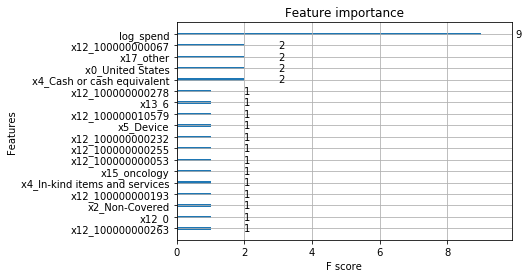

In [172]:
xgb.plot_importance(bst)

the ensamble model did yield to a much better result compared with single models <br>
and the feature importance reflected of what we saw in the single model result

try cv for svm

In [ ]:
clf = svm.SVC()
clf.train(X_train,y_train)
grid

In [177]:
clf=RandomForestClassifier()

Leverage random search to find parameters using random forest<br>

In [178]:
from scipy.stats import randint
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
n_iter_search = 20
random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=200, cv=5)

In [1]:
#random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None,
                                                    oob_sc...
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025B04732048>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025B0720B860>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [182]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 5}

In [183]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [189]:
random_search.cv_results_['mean_test_score'][random_search.cv_results_['rank_test_score']-1][:10]

array([0.96818638, 0.9688575 , 0.87053663, 0.96403524, 0.96813305,
       0.85494093, 0.96748416, 0.87663446, 0.7940115 , 0.95988853])

In [205]:
random_search.cv_results_['rank_test_score'][:10]-1

array([171, 119, 167, 103,  38, 170, 140, 195,  73, 105])

In [206]:
for i in random_search.cv_results_['rank_test_score'][:10]-1:
    print(random_search.cv_results_['params'][i])

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 5}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 9}
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'min_samples_split': 9}
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_split': 7}
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 5}
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_split': 3}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_split': 2}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_split': 5}
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_split': 7}
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'm

In [207]:
model = random_search.best_estimator_

In [208]:
X_train.columns

Index(['x0_Austria', 'x0_Barbados', 'x0_Belgium', 'x0_Brazil', 'x0_Canada',
       'x0_Denmark', 'x0_Finland', 'x0_France', 'x0_Germany',
       'x0_Great Britain (Uk)',
       ...
       'x17_boehringer', 'x17_eisai', 'x17_incyte', 'x17_janssen', 'x17_merck',
       'x17_novo', 'x17_other', 'x17_pfizer', 'x17_sanofi', 'log_spend'],
      dtype='object', length=266)

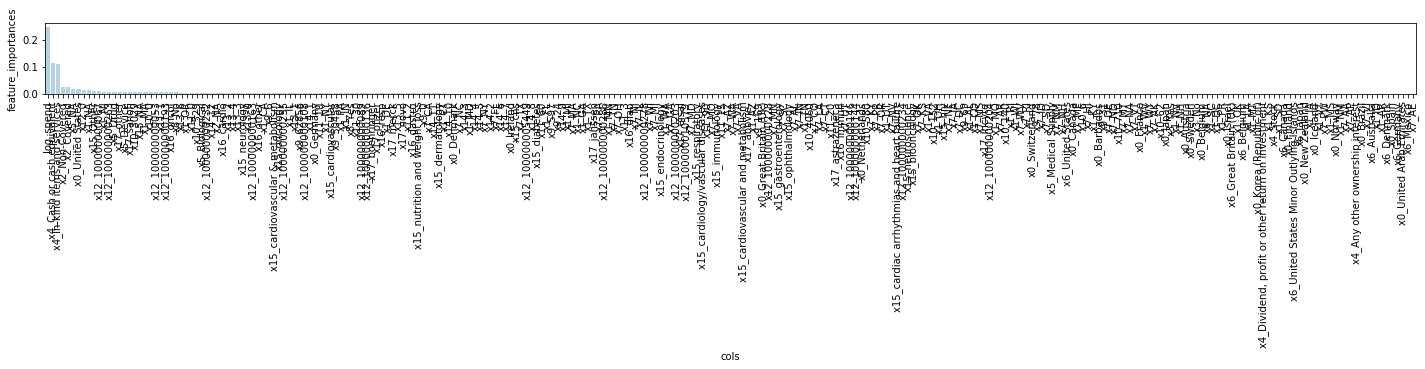

In [210]:
# get the encoded col_names
cols = X_train.columns.tolist()
# get the ordinal vars
 
# add the continuous vars
 
 
model_res = pd.DataFrame(data={'cols': cols,
                               'feature_importances': model.feature_importances_})

model_res.sort_values(by='feature_importances', ascending=False, inplace=True)
 
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(x='cols', y='feature_importances', data=model_res, ax=ax, color='lightblue')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [213]:
tree=DecisionTreeClassifier(   criterion= 'gini', max_depth=None, max_features=9, min_samples_split=5)

In [ ]:
tree.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree.score(X_train,y_train),tree.score(X_test,y_test)))

tree_dot = export_graphviz(tree, out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)

In [3]:
#graph